In [1]:
import tensorflow as tf
# 預設情況下，tensorflow會為了避免碎片化的記憶體造成效能不佳的情況而一次性的佔用顯卡所有記憶體，
# 這部份可以透過tf.config來限制硬體資源以及指定顯卡記憶體的使用。
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                # If memory growth is enabled for a PhysicalDevice, 
                # the runtime initialization will not allocate all memory on the device. 
                # Memory growth cannot be configured on a PhysicalDevice with virtual devices configured.
                tf.config.experimental.set_memory_growth(gpu, True)
            # 指定使用哪顆GPU
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)

In [2]:
select_gpu(0)
epochs = 20
model_name = 'bert-base'
sequence_length = 48
batch_size = 512

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [3]:
import pandas as pd
import numpy as np
import json

In [4]:
data_path = '/home/Danny/Data-Mining/lab2/kaggle/data/'

In [5]:
json_list = list()
with open(data_path + 'tweets_DM.json' , 'r') as file:
    for line in file:
        json_list.append(json.loads(line))

In [6]:
tweet_list = list()
for json in json_list:
    tweet_id = json['_source']['tweet']['tweet_id']
    hashtags = json['_source']['tweet']['hashtags']
    hashtag = ' '.join(hashtags)
    text = json['_source']['tweet']['text']
#     text = text + ' ' + hashtag
    tweet_list.append([tweet_id, text])

In [7]:
emotion_df = pd.read_csv(data_path + 'emotion.csv')
emotion_df

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [8]:
identification_df = pd.read_csv(data_path + 'data_identification.csv')
identification_df

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [9]:
emoji_dict = {
    "😂": "smile",
    "😇": "smile",
    "😀": "smile",
    "🎉": "party",
    "😳": "embarrassed",
    "😔": "sadface",
    "👀": "shifty",
    "🤷": "shrugging",
    "💔": "brokenhearted",
    "👻": "ghost",
    "😍": "heart",
    "🙄": "disdain",
    "💖": "heart",
    "✌": "victory",
    "🎶": "music",
    "😱": "shock",
    "😃": "smile",
    "😒": "unsatisfied",
    "👊": "brofist",
    "😄": "smile",
    "🌞": "smile",
    "🙌": "celebration",
    "😁": "smile",
    "🤗": "hugging",
    "🤣": "rofl",
    "🌈": "gaypride",
    "😉": "winking",
    "💞": "heart",
    "🙃": "irony",
    "😜": "winking",
    "😭": "bawling",
    "🤔": "thinker",
    "😎": "cool",
    "💛": "heart",
    "💚": "heart",
    "💃": "fun",
    "💗": "heart",
    "😬": "awkward",
    "😌": "relieved",
    "😅": "whew",
    "💋": "kiss",
    "🙈": "laugh",
    "😊": "smile",
    "👌": "okay",
    "😡": "angry",
    "😘": "kiss",
    "😩": "weary",
    "🔥": "excellent",
    "💙": "heart",
    "💕": "heart",
    "👏": "clapping",
    "👍": "thumbsup",
    "💯": "perfect",
    "💜": "heart",
    "🕘" : "late",
    "😡" : "angry",
    "😒" : "dissatisfied",
    "😤" : "angry",
    "😠" : "angry",
    "😑" : "annoy",
    "😰": "anxious",
    "😯": "surprise",
    "😨": "scared",
    "😲": "astonished",
    "💪": "strong",
    "🤦": "facepalm",
    "✨": "sparkle",
    "😢": "crying",
    "💓": "heart",
    "👑": "crown",
    "🤘": "rockon",
    "🌹": "rose",
    "😋": "delicious",
    "😏": "flirting",
    "😆": "smile",
    "😫": "exhausted",
    "😦": "frowning",
    "🙏": "please",
}

In [10]:
frequent_name_dict = {
    "#realdonaldtrump": "sadness",
    "#fifthharmony": "sadness",
    "#mostrequestlive": "sadness",
    "#onairromeo": "sadness",
    "#matthardybrand": "sadness",
}

In [11]:
text_df = pd.DataFrame(tweet_list, columns=['tweet_id', 'text'])
text_df

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [12]:
# import re
# def replace_word(text):
#     text_list = text.split()
#     for i, j in enumerate(text_list):
#         if j in emoji_dict:
#             text_list[i] = emoji_dict[j]
#         if j in frequent_name_dict:
#             text_list[i] = frequent_name_dict[j]
#     text = ' '.join(text_list)
#     text = re.sub('<lh>|<|>|@|#|', '', text)
#     return text.split()

In [13]:
# text_df['token'] = text_df['text'].apply(lambda s : s.split())
# text_df

In [14]:
# %%time
# import nltk
# from nltk.tokenize import TweetTokenizer
# tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
# text_df['token'] = text_df['text'].apply(lambda s : s.lower())
# text_df['token'] = text_df['token'].apply(lambda s : tweet_tokenizer.tokenize(s))
# text_df['token'] = text_df['token'].apply(lambda s : ' '.join(s))
# text_df['token'] = text_df['token'].apply(lambda s : replace_word(s))
# text_df

In [15]:
%%time
from kashgari.tokenizers import BertTokenizer
vocab_path = '/home/Danny/pretrain_model/{}/vocab.txt'.format(model_name)
tokenizer = BertTokenizer.load_from_vocab_file(vocab_path)
text_df['token'] = text_df['text'].apply(lambda s : tokenizer.tokenize(s))
text_df

CPU times: user 4min 38s, sys: 970 ms, total: 4min 39s
Wall time: 4min 49s


,tweet_id,text,token
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...","[people, who, post, "", add, me, on, #, snap, #..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[@, brian, ##kla, ##as, as, we, see, ,, trump,..."
2,0x28b412,"Confident of your obedience, I write to you, k...","[confident, of, your, obedience, ,, i, write, ..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,"[now, iss, ##a, is, stalking, tasha, 😂, ##😂, #..."
4,0x2de201,"""Trust is not the same as faith. A friend is s...","["", trust, is, not, the, same, as, faith, ., a..."
...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,"[when, you, buy, the, last, 2, tickets, remain..."
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,"[i, swear, all, this, hard, work, gone, pay, o..."
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,"[@, parcel, ##2, ##go, no, card, left, when, i..."
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...","[ah, ,, corporate, life, ,, where, you, can, d..."


In [16]:
test_df = identification_df[identification_df['identification'] == 'test']
# test_df

In [17]:
train_df = text_df.merge(emotion_df, left_on='tweet_id', right_on='tweet_id')
# train_df

In [18]:
x_list = train_df['token'].to_list()
y_list = train_df['emotion'].to_list()
print(len(x_list))
print(len(y_list))

1455563
1455563


In [19]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x_list, y_list, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(test_x), len(test_y))
print(len(valid_x), len(valid_y))

931560 931560
291113 291113
232890 232890


In [24]:
%%time
import kashgari
from kashgari.tasks.classification import BiLSTM_Model
kashgari.config.use_cudnn_cell = True
import logging
logging.basicConfig(level='DEBUG')
from kashgari.embeddings import BertEmbedding
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)
embedding = BertEmbedding(model_folder=embedding_path,
                           trainable=True,
                           task='kashgari.CLASSIFICATION',
                           sequence_length='auto',                           
                          )
model = BiLSTM_Model(embedding)
history = model.fit(train_x, 
                    train_y, 
                    valid_x, 
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
         )

2020-12-05 14:59:10,836 [DEBUG] kashgari - ------------------------------------------------
2020-12-05 14:59:10,837 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-05 14:59:10,837 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-base/bert_config.json
2020-12-05 14:59:10,838 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-base/vocab.txt
2020-12-05 14:59:10,838 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-base/bert_model.ckpt
2020-12-05 14:59:10,839 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]'

Epoch 1/20
1819/1819 [==============================] - 1443s 794ms/step - loss: 1.2867 - accuracy: 0.5328 - val_loss: 1.1536 - val_accuracy: 0.5812
Epoch 2/20
1819/1819 [==============================] - 1444s 794ms/step - loss: 1.1357 - accuracy: 0.5888 - val_loss: 1.1014 - val_accuracy: 0.6005
Epoch 3/20
1819/1819 [==============================] - 1443s 793ms/step - loss: 1.0887 - accuracy: 0.6054 - val_loss: 1.0850 - val_accuracy: 0.6051
Epoch 4/20
1819/1819 [==============================] - 1443s 794ms/step - loss: 1.0582 - accuracy: 0.6164 - val_loss: 1.0773 - val_accuracy: 0.6091
Epoch 5/20
1819/1819 [==============================] - 1443s 793ms/step - loss: 1.0346 - accuracy: 0.6245 - val_loss: 1.0783 - val_accuracy: 0.6096
Epoch 6/20
1819/1819 [==============================] - 1442s 793ms/step - loss: 1.0150 - accuracy: 0.6316 - val_loss: 1.0783 - val_accuracy: 0.6101
Epoch 7/20
1819/1819 [==============================] - 1442s 793ms/step - loss: 0.9980 - accuracy: 0.6374

In [25]:
%%time
model_path = 'model/{}-epoch-{}'.format(model_name, epochs)
model.save(model_path)
model.evaluate(test_x, test_y)

2020-12-05 23:03:33,366 [INFO] kashgari - model saved to /home/Danny/Data-Mining/lab2/kaggle/kashgari/model/bert-base-epoch-20
2020-12-05 23:03:33,435 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 125
2020-12-05 23:03:36,909 [DEBUG] kashgari - predict input shape (2, 291113, 125) x: 
(array([[ 101, 2042, 1037, ...,    0,    0,    0],
       [ 101, 3582, 2256, ...,    0,    0,    0],
       [ 101, 4687, 2065, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2499, ...,    0,    0,    0],
       [ 101, 1026, 1048, ...,    0,    0,    0],
       [ 101, 6343, 3793, ...,    0,    0,    0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32))
2020-12-05 23:21:11,118 [DEBUG] kashgari - predict output shape (291113, 8)
2020-12-05 23:21:11,280 [DEBUG] kashgari - 

              precision    recall  f1-score   support

       anger     0.5586    0.2688    0.3630      7946
anticipation     0.6625    0.6107    0.6355     49984
     disgust     0.4768    0.4860    0.4814     27669
        fear     0.6176    0.4895    0.5461     12846
         joy     0.6461    0.7808    0.7071    102943
     sadness     0.5195    0.5642    0.5409     38745
    surprise     0.5669    0.2589    0.3554      9816
       trust     0.5523    0.4276    0.4820     41164

    accuracy                         0.6004    291113
   macro avg     0.5750    0.4858    0.5139    291113
weighted avg     0.5964    0.6004    0.5910    291113

CPU times: user 9min 58s, sys: 44.5 s, total: 10min 42s
Wall time: 18min 58s


{'detail': {'anger': {'precision': 0.5585774058577406,
   'recall': 0.2688144978605588,
   'f1-score': 0.36295666949872557,
   'support': 7946},
  'anticipation': {'precision': 0.6625496537801993,
   'recall': 0.610655409731114,
   'f1-score': 0.6355449595535798,
   'support': 49984},
  'disgust': {'precision': 0.4767779904984755,
   'recall': 0.48603129856518124,
   'f1-score': 0.48136017897091715,
   'support': 27669},
  'fear': {'precision': 0.617621058835085,
   'recall': 0.48949089210649227,
   'f1-score': 0.5461414860815564,
   'support': 12846},
  'joy': {'precision': 0.6460866979077077,
   'recall': 0.7808107399240356,
   'f1-score': 0.7070885675076535,
   'support': 102943},
  'sadness': {'precision': 0.5195132385796454,
   'recall': 0.5641502129307008,
   'f1-score': 0.5409124092107055,
   'support': 38745},
  'surprise': {'precision': 0.5669344042838019,
   'recall': 0.25886308068459657,
   'f1-score': 0.35543432647922785,
   'support': 9816},
  'trust': {'precision': 0.5522

DEBUG:matplotlib:CONFIGDIR=/home/Danny/.config/matplotlib
DEBUG:matplotlib:(private) matplotlib data path: /home/Danny/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:matplotlib data path: /home/Danny/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/Danny/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.2.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconf

DEBUG:matplotlib:CACHEDIR=/home/Danny/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/Danny/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'aakar' (aakar-medium.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'LKLUG' (lklug.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gubbi' (Gubbi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Thin.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
DE

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-L.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukti Narrow' (MuktiNarrowBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:fin

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'aakar' (aakar-medium.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'LKLUG' (lklug.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Thin.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Uroob' (Uroob.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukti Narrow' (MuktiNarrowBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: sco

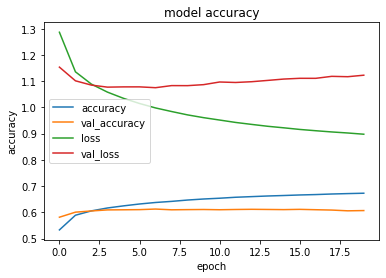

In [26]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [27]:
# model_path = 'model/{}_epoch_{}'.format(model_name, epochs)
# model = kashgari.utils.load_model(model_path)
# model.evaluate(test_x, test_y)

In [28]:
test_df = test_df.merge(text_df, left_on='tweet_id', right_on='tweet_id')
# test_df

In [29]:
text_list = test_df['token'].tolist()
# text_list

In [30]:
%%time
predict_list = model.predict(text_list)
# predict_list

2020-12-05 23:21:24,128 [DEBUG] kashgari - predict input shape (2, 411972, 149) x: 
(array([[ 101, 1030, 5292, ...,    0,    0,    0],
       [ 101, 1030, 4419, ...,    0,    0,    0],
       [ 101, 2559, 2005, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2074, ...,    0,    0,    0],
       [ 101, 3713, 2069, ...,    0,    0,    0],
       [ 101, 2113, 2054, ...,    0,    0,    0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32))
2020-12-05 23:51:46,982 [DEBUG] kashgari - predict output shape (411972, 8)
2020-12-05 23:51:47,209 [DEBUG] kashgari - predict output argmax: [3 3 6 ... 4 0 0]


CPU times: user 14min 52s, sys: 1min 4s, total: 15min 57s
Wall time: 30min 28s


In [31]:
test_df['predict'] = predict_list
# test_df

In [32]:
output_df = test_df[['tweet_id', 'predict']]
output_df = output_df.rename(columns={'tweet_id':'id', 'predict':'emotion'})
# output_df

In [33]:
output_path = 'output/{}-epoch-{}.csv'.format(model_name, epochs)
output_df.to_csv(output_path, index=False, header=True)